## [1] Import Libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import pickle
import warnings
warnings.filterwarnings("ignore")

## [2] Calculate Fracture Maps for All of Greenland

This calculates the final fracture probability map in Figure 4 from the 240 model ensemble.

In [2]:
# Directory with strain rate maps for the entire Greenland ice sheet (with velocity perturbations)
strain_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\GrISStrainRate\\"
# Directory with surface temperatures for the entire ice sheet
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\"

# List of velocity perturbation iterations
strain_experiments = ["Exp0", "Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7","Exp8", "Exp9"]
# List of correlation structures for GRFs
correlation = ["Gaussian", "Exponential"]
# List of temperature averaging time periods
temp_maps = ["Annual"]
# List of temperature models to test
temp_model = ["RACMO", "MAR", "CARRA"]
# List of rate factor parameterizations to try
viscosity = [0, 1]
# List of crevasse maps
crev_maps = ["MapA", "MapB"]

# Load our precalculated tensile stresses so we can just threshold the stress maps without re-training the model
with open('TensileStrengthResults_DualMap2.pickle', 'rb') as f:
    results = pickle.load(f)

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

# Hooke Viscosity Model Parameters
B0 = 2.207     # Pa year^-1
T0 = 3155                 # K
C = 0.16612               # K^k
T_r = 273.39              # K
k_coeff = 1.17

# Probability axis
axis = np.arange(0,350000,100).reshape(-1,1)

count = 1
# Total number of models in the ensemble
total = (len(temp_maps)*len(temp_model)*len(viscosity)*len(correlation)*len(strain_experiments)*len(crev_maps))
# Store the final probability of fracture map for all of Greenland
probability = np.zeros((10920,6020))
for q in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for k in viscosity:
                for m in strain_experiments:
                    for w in correlation:
                        print(100*count/total)
    
                        # Load the strain rate maps
                        eXX_file = strain_dir+m+"_eXX_"+w+".tif"
                        eYY_file = strain_dir+m+"_eYY_"+w+".tif"
                        eXY_file = strain_dir+m+"_eXY_"+w+".tif"
    
                        # Read in all three components of the strain rate
                        dataset = rio.open(eXX_file)
                        eXX = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eYY_file)
                        eYY = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eXY_file)
                        eXY = dataset.read(1)
                        dataset.close()
    
                        # Load the surface temperature dataset
                        temp_file = temp_dir+j+"Training\\"+j+i+"_250m.tif"
    
                        # Load data for the appropriate temperature field
                        dataset = rio.open(temp_file)
                        temp = dataset.read(1)
                        dataset.close()
    
                        # Convert temperature field to degrees Kelvin
                        temp = temp + 273.15
    
                        if k == 0:   # Cuffey and Patterson rate factor
                            # Calculate creep coefficient with temperature dependence of activation energy
                            A = np.zeros(temp.shape)
                            A[temp > 263.0] = A_star*np.exp((-Qc2/R)*((1/temp[temp > 263.0]) - (1/T_start)))
                            A[temp <= 263.0] = A_star*np.exp((-Qc/R)*((1/temp[temp <= 263.0]) - (1/T_start)))
                            # Convert strain rates from 1/yr to 1/s
                            eXX_s = eXX*(1/(60*60*24*365))
                            eXY_s = eXY*(1/(60*60*24*365))
                            eYY_s = eYY*(1/(60*60*24*365))
                            #Calculate effective stress
                            eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)
                            # Calculate deviatoric stress at surface
                            tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
                            tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
                            tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s 
                        elif k == 1:    # Hooke rate factor
                            B = B0*np.exp((T0/temp) - (C/np.power(T_r - temp, k_coeff)))
                            #Calculate effective stress
                            eE = np.sqrt(0.5*(eXX**2 + eYY**2 + (-eXX - eYY)**2) + eXY**2)
                            # Calculate deviatoric stress at surface
                            tau_xx = B*(eE**((1-n)/n))*eXX
                            tau_yy = B*(eE**((1-n)/n))*eYY
                            tau_xy = B*(eE**((1-n)/n))*eXY
    
                        # Calculate full Cauchy stress at surface
                        sigma_xx = 2.*tau_xx + tau_yy
                        sigma_yy = 2.*tau_yy + tau_xx
    
                        # Calculate principal stresses
                        sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
                        sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
    
                        # Von Mises Stress over whole area of interest
                        sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)
    
                        a = crev_maps.index(q)
                        b = temp_maps.index(i)
                        c = temp_model.index(j)
                        d = viscosity.index(k)
                        e = strain_experiments.index(m)
                        f = correlation.index(w)
                                              
                        thresh = results['err_ts'][a,b,c,d,e,f]
    
                        # Threshold the von Mises stress - if it's above the threshold predict fracture (1), if it's 
                        # below or the maximum principal stress is negative, predict no fracture (0)
                        mask = np.zeros(sigmaV.shape)
                        mask[sigmaV >= thresh] = 1
                        mask[sigma1 < 0] = 0
    
                        # Add to the probability map
                        probability = probability + mask
                        count = count + 1

# Rescale from counts of models to fraction of total models
probability = probability/(len(temp_maps)*len(temp_model)*len(viscosity)*len(correlation)*len(strain_experiments)*len(crev_maps))

# Save results to a text file
np.savetxt("AnnualGreenlandProbability_Final.txt",probability)

0.4166666666666667
0.8333333333333334
1.25
1.6666666666666667
2.0833333333333335
2.5
2.9166666666666665
3.3333333333333335
3.75
4.166666666666667
4.583333333333333
5.0
5.416666666666667
5.833333333333333
6.25
6.666666666666667
7.083333333333333
7.5
7.916666666666667
8.333333333333334
8.75
9.166666666666666
9.583333333333334
10.0
10.416666666666666
10.833333333333334
11.25
11.666666666666666
12.083333333333334
12.5
12.916666666666666
13.333333333333334
13.75
14.166666666666666
14.583333333333334
15.0
15.416666666666666
15.833333333333334
16.25
16.666666666666668
17.083333333333332
17.5
17.916666666666668
18.333333333333332
18.75
19.166666666666668
19.583333333333332
20.0
20.416666666666668
20.833333333333332
21.25
21.666666666666668
22.083333333333332
22.5
22.916666666666668
23.333333333333332
23.75
24.166666666666668
24.583333333333332
25.0
25.416666666666668
25.833333333333332
26.25
26.666666666666668
27.083333333333332
27.5
27.916666666666668
28.333333333333332
28.75
29.1666666666666

## [3] Partitioning Uncertainty for Fracture Extent

This code creates maps of fracture probability where the only source of uncertainty is EITHER the temperature averging time period, velocity, temperature, viscosity, or the observations. In this way, we can determine which factors most contribute to spatial uncertainty in fracture extent in this model. 

In [2]:
# Directory with strain rate maps for the entire Greenland ice sheet (with velocity perturbations)
strain_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\GrISStrainRate\\"
# Directory with surface temperatures for the entire ice sheet
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\"
# Directory with ice slab outline
ice_dir = "C:\\Users\\rtc84\\OneDrive - Cornell University\\Research_FirstAuthor\\IceSlabCrevasses\\FinalModel\\"

strain_experiments_org = ["Exp0", "Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7","Exp8", "Exp9"]
correlation_org = ["Gaussian", "Exponential"]
temp_maps_org = ["Annual", 'DJF', 'JJA']
temp_model_org = ["RACMO", "MAR", "CARRA"]
viscosity_org = ["0", "1"]
crev_maps_org = ["MapA", "MapB"]

# Load our precalculated tensile stresses so we can just threshold the stress maps without re-training the model
with open('./data/TensileStrengthResults_Final.pickle', 'rb') as f:
    results = pickle.load(f)

# Load ice slab file
dataset = rio.open(ice_dir+"IceSlabMask.tif")
ice_slabs = dataset.read(1)
dataset.close()
ice_slabs[2752:,2428:] = 0

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

# Hooke Viscosity Model Parameters
B0 = 2.207     # Pa year^-1
T0 = 3155                 # K
C = 0.16612               # K^k
T_r = 273.39              # K
k_coeff = 1.17

# Probability axis
axis = np.arange(0,350000,100).reshape(-1,1)

df = pd.read_csv("./data/UncertaintyPartitioning.csv")
error = []

for row in df.iterrows():
    if row[1].crev_maps == "all":
        crev_maps = crev_maps_org
    else:
        crev_maps = [row[1].crev_maps]
        
    if row[1].temp_maps == "all":
        temp_maps = temp_maps_org
    else:
        temp_maps = [row[1].temp_maps]

    if row[1].temp_model == "all":
        temp_model = temp_model_org
    else:
        temp_model = [row[1].temp_model]
        
    if row[1].viscosity == "all":
        viscosity = viscosity_org
    else:
        viscosity = [row[1].viscosity]

    if row[1].strain_experiments == "all":
        strain_experiments = strain_experiments_org
    else:
        strain_experiments = [row[1].strain_experiments]

    if row[1].correlation == "all":
        correlation = correlation_org
    else:
        correlation = [row[1].correlation]

    print(crev_maps, temp_maps, temp_model, viscosity, strain_experiments, correlation)

    count = 1
    # Total number of models in the ensemble
    total = (len(temp_maps)*len(temp_model)*len(viscosity)*len(correlation)*len(strain_experiments)*len(crev_maps))
    # Store the final probability of fracture map for all of Greenland
    probability = np.zeros((10920,6020))
    for m in strain_experiments:
        for q in crev_maps:
            for i in temp_maps:
                for j in temp_model:
                    for k in viscosity:
                        for w in correlation:   
                            # Load the strain rate maps
                            eXX_file = strain_dir+m+"_eXX_"+w+".tif"
                            eYY_file = strain_dir+m+"_eYY_"+w+".tif"
                            eXY_file = strain_dir+m+"_eXY_"+w+".tif"
        
                            # Read in all three components of the strain rate
                            dataset = rio.open(eXX_file)
                            eXX = dataset.read(1)
                            dataset.close()
                            dataset = rio.open(eYY_file)
                            eYY = dataset.read(1)
                            dataset.close()
                            dataset = rio.open(eXY_file)
                            eXY = dataset.read(1)
                            dataset.close()
        
                            # Load the surface temperature dataset
                            temp_file = temp_dir+j+"Training\\"+j+i+"_250m.tif"
        
                            # Load data for the appropriate temperature field
                            dataset = rio.open(temp_file)
                            temp = dataset.read(1)
                            dataset.close()
        
                            # Convert temperature field to degrees Kelvin
                            temp = temp + 273.15
        
                            if k == "0":   # Cuffey and Patterson rate factor
                                # Calculate creep coefficient with temperature dependence of activation energy
                                A = np.zeros(temp.shape)
                                A[temp > 263.0] = A_star*np.exp((-Qc2/R)*((1/temp[temp > 263.0]) - (1/T_start)))
                                A[temp <= 263.0] = A_star*np.exp((-Qc/R)*((1/temp[temp <= 263.0]) - (1/T_start)))
                                # Convert strain rates from 1/yr to 1/s
                                eXX_s = eXX*(1/(60*60*24*365))
                                eXY_s = eXY*(1/(60*60*24*365))
                                eYY_s = eYY*(1/(60*60*24*365))
                                #Calculate effective stress
                                eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)
                                # Calculate deviatoric stress at surface
                                tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
                                tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
                                tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s 
                            elif k == "1":    # Hooke rate factor
                                B = B0*np.exp((T0/temp) - (C/np.power(T_r - temp, k_coeff)))
                                #Calculate effective stress
                                eE = np.sqrt(0.5*(eXX**2 + eYY**2 + (-eXX - eYY)**2) + eXY**2)
                                # Calculate deviatoric stress at surface
                                tau_xx = B*(eE**((1-n)/n))*eXX
                                tau_yy = B*(eE**((1-n)/n))*eYY
                                tau_xy = B*(eE**((1-n)/n))*eXY
        
                            # Calculate full Cauchy stress at surface
                            sigma_xx = 2.*tau_xx + tau_yy
                            sigma_yy = 2.*tau_yy + tau_xx
        
                            # Calculate principal stresses
                            sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
                            sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
        
                            # Von Mises Stress over whole area of interest
                            sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)
    
                            a = crev_maps_org.index(q)
                            b = temp_maps_org.index(i)
                            c = temp_model_org.index(j)
                            d = viscosity_org.index(k)
                            e = strain_experiments_org.index(m)
                            f = correlation_org.index(w)
                                                  
                            thresh = results['err_ts'][a,b,c,d,e,f]
        
                            # Threshold the von Mises stress - if it's above the threshold predict fracture (1), if it's 
                            # below or the maximum principal stress is negative, predict no fracture (0)
                            mask = np.zeros(sigmaV.shape)
                            mask[sigmaV >= thresh] = 1
                            mask[sigma1 < 0] = 0
        
                            # Add to the probability map
                            probability = probability + mask
                            count = count + 1
    
    # Rescale from counts of models to fraction of total models
    probability = probability/(len(temp_maps)*len(temp_model)*len(viscosity)*len(correlation)*len(strain_experiments)*len(crev_maps))

    # Block out areas covered by firn aquifers
    probability[2752:,2428:] = 0
    slabs = np.matrix.flatten(ice_slabs)
    fracs = np.matrix.flatten(probability)

    # Find fraction of total ice slab area
    slab_area = np.size(slabs[slabs == 1])
    frac_area = np.size(fracs[np.logical_and(np.logical_and(fracs > 0, fracs < 1),slabs == 1)])
    print(frac_area/slab_area)
    error.append(frac_area/slab_area)
    
# Save results to a text file
np.savetxt("UncertaintyPartitiong_FractureExtent.txt",error)

['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp2'] ['Exponential']
0.025089372349385308
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp3'] ['Exponential']
0.028097983477990758
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp4'] ['Exponential']
0.026627569488402676
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp5'] ['Exponential']
0.02688802757439868
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp6'] ['Exponential']
0.026023392124985723
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp7'] ['Exponential']
0.02661529379992336
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp8'] ['Exponential']
0.025122997061306922
['IE'] ['DJF'] ['MAR'] ['0', '1'] ['Exp9'] ['Exponential']
0.025013049590579102
['IE'] ['DJF'] ['CARRA'] ['0', '1'] ['Exp0'] ['Gaussian']
0.025446968492043753
['IE'] ['DJF'] ['CARRA'] ['0', '1'] ['Exp1'] ['Gaussian']
0.024410473403920323
['IE'] ['DJF'] ['CARRA'] ['0', '1'] ['Exp2'] ['Gaussian']
0.02576773756926424
['IE'] ['DJF'] ['CARRA'] ['0', '1'] ['Exp3'] ['Gaussian']
0.023656319150821243
['IE'] ['DJF'] ['CARRA'] ['0', '1'] ['Exp4'] ['

## [5] Uncertainty Partitioning for Tensile Strength

This code takes all of the pre-trained data on tensile strength from 240 model ensemble, breaks it out into model subsets where only one variable is changed a time, and stores the results. 

In [2]:
# Load our precalculated tensile stresses so we can just threshold the stress maps without re-training the model
with open('./data/TensileStrengthResults_Final.pickle', 'rb') as f:
    results = pickle.load(f)

# List of velocity perturbation experiment names
strain_experiments = ["Exp0", "Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7","Exp8", "Exp9"]
# List of covariance structure options
correlation = ["Gaussian", "Exponential"]
# List of temperature averaging options to test
temp_maps = ["Annual", "DJF", "JJA"]
# List of temperatur models to test
temp_model = ["RACMO", "MAR", "CARRA"]
# List of rate factor parameterizations to try, 0 = Cuffey & Patterson, 1 = Hooke
viscosity = [0, 1]
# List of crevasse maps
crev_maps = ["MapA", "MapB"]

# Uncertainty from temperature averaging time period
delta_averaging = [];
for p in crev_maps:
    for j in temp_model:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,:,c,d,e,f]
                    delta_averaging.append(np.max(thresh) - np.min(thresh))

# Uncertainty from source of temperature data
delta_model = [];
for p in crev_maps:
    for i in temp_maps:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,b,:,d,e,f]
                    delta_model .append(np.max(thresh) - np.min(thresh))

delta_viscosity = [];
for p in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    e = temp_model.index(j)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,b,c,:,e,f]
                    delta_viscosity.append(np.max(thresh) - np.min(thresh))

# Uncertainty from velocity errors
delta_velocity = [];
for p in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for k in viscosity:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                        
                    thresh = results['err_ts'][a,b,c,d,:,:]
                    delta_velocity.append(np.max(thresh) - np.min(thresh))

# Uncertainty from crevasse mapping errors/differences
delta_obs = [];
for i in temp_maps:
    for j in temp_model:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    b = temp_maps.index(i)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][:,b,c,d,e,f]
                    delta_obs.append(np.max(thresh) - np.min(thresh))

## [6] Uncertainty Partitioning Figure

This code reproduces Figure 6. 

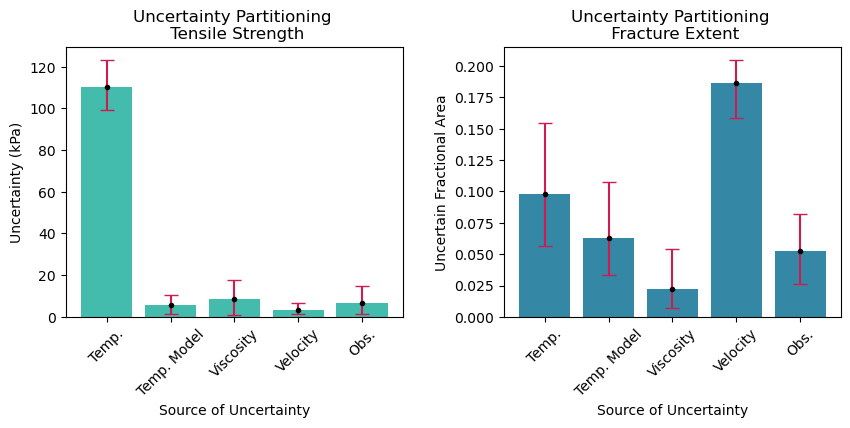

In [3]:
all_data = np.ndarray.flatten(results['err_ts'])

# Data on uncertainty in tensile strength from previous code block
x = [1,2,3,4,5]
labels = ["Temp.", "Temp. Model", "Viscosity", "Velocity", "Obs."]
middle = np.array([np.mean(delta_averaging), np.mean(delta_model), np.mean(delta_viscosity), np.mean(delta_velocity), np.mean(delta_obs)])
lower = [middle[0]-np.min(delta_averaging), middle[1]-np.min(delta_model), middle[2]-np.min(delta_viscosity),middle[3]-np.min(delta_velocity),
        middle[4]-np.min(delta_obs)]
upper = [np.max(delta_averaging)-middle[0], np.max(delta_model)-middle[1], np.max(delta_viscosity)-middle[2], np.max(delta_velocity)-middle[3],
        np.max(delta_obs)-middle[4]]
asymmetric_error = np.array(list(zip(lower, upper))).T

# Load saved data on uncertainty from fracture extent calculated earlier in this notebook
extent = pd.read_csv("./data/UncertaintyPartitioning.csv")
obs = extent['error'][extent['crev_maps'] == "all"]
temp_map = extent['error'][extent['temp_maps'] == "all"]
temp_model = extent['error'][extent['temp_model'] == "all"]
velocity = extent['error'][extent['strain_experiments'] == "all"]
viscosity = extent['error'][extent['viscosity'] == "all"]

x2 = [1,2,3,4,5]
labels2 = ["Temp.", "Temp. Model", "Viscosity", "Velocity", "Obs."]
middle2 = np.array([np.mean(temp_map), np.mean(temp_model), np.mean(viscosity), np.mean(velocity), np.mean(obs)])
lower2 = [middle2[0]-np.min(temp_map), middle2[1]-np.min(temp_model), middle2[2]-np.min(viscosity), middle2[3]-np.min(velocity), middle2[4]-np.min(obs)]
upper2 = [np.max(temp_map)-middle2[0], np.max(temp_model)-middle2[1], np.max(viscosity)-middle2[2], np.max(velocity)-middle2[3], np.max(obs)-middle2[4]]
asymmetric_error2 = np.array(list(zip(lower2, upper2))).T

# Plot everything!
plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))
ax1.bar(x, middle/1000, tick_label=labels, color="#43BBAD")
ax1.errorbar(x, middle/1000, yerr=asymmetric_error/1000, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
ax1.set_ylabel("Uncertainty (kPa)")
ax1.set_xlabel("Source of Uncertainty")
ax1.set_xticklabels(labels, rotation=45)
ax1.set_title("Uncertainty Partitioning \n Tensile Strength")
ax2.bar(x2, middle2, tick_label=labels2, color="#3487A5")
ax2.errorbar(x2, middle2, yerr=asymmetric_error2, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
#ax2.errorbar(x, middle/1000, yerr=asymmetric_error/1000, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
ax2.set_ylabel("Uncertain Fractional Area")
ax2.set_xlabel("Source of Uncertainty")
ax2.set_xticklabels(labels2, rotation=45)
ax2.set_title("Uncertainty Partitioning \n Fracture Extent")
plt.subplots_adjust(wspace=0.3)
#plt.savefig("C:\\Users\\rtc84\\OneDrive - Cornell University\\Research_FirstAuthor\\IceSlabCrevasses\\Revision\\RevisedFigures\\Fig6_Uncertainty_Revised.svg")
plt.show()